In [148]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
%matplotlib inline

#QUESTION 1

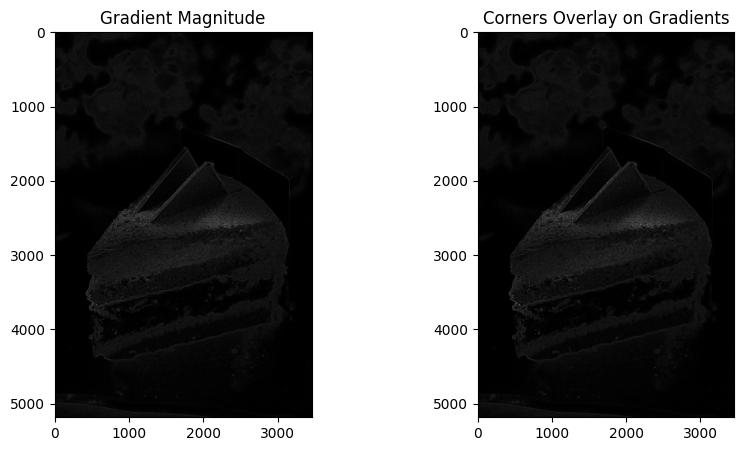

In [149]:
#Q1
image = cv2.imread('./cake2.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray=np.float32(gray)
# Compute gradients using Sobel operator
grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)  # Gradient in X direction
grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)  # Gradient in Y direction

# Compute gradient magnitude
magnitude = np.sqrt(grad_x**2 + grad_y**2)

# Normalize magnitude for visualization
magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
dst = cv2.cornerHarris(np.float32(gray), 2, 3, 0.04)
dst = cv2.dilate(dst, None)

# Threshold to find strong corners
threshold = 0.1 * dst.max()
corners = dst > threshold

# Create a copy of the gradient magnitude to overlay corners
overlay = np.copy(magnitude)
overlay[corners] = 255  # Highlight corners

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Gradient Magnitude")
plt.imshow(magnitude, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Corners Overlay on Gradients")
plt.imshow(overlay, cmap='gray')
plt.show()

1. Circular Shapes (e.g., Pepperoni):
Harris Corner Detection works best with abrupt intensity changes, typically found at edges and sharp angles.
Circular shapes have smooth gradients, leading to a weaker corner response. Thus, corners on pepperoni slices may not be detected reliably.
2. Crust Edges:
The crust, especially if irregularly shaped or with sharp edges, may produce strong corner responses.
Rounded parts of the crust might not be detected as corners due to the lack of sharp changes in intensity.
3. Cheese Texture:
The cheese texture often has high-frequency noise due to random patterns of melted cheese or bubbles.
Harris Corner Detection may erroneously mark these noisy regions as corners, as it lacks semantic understanding of textures.

Why Harris Struggles:

Circular Shapes: Harris relies on significant intensity changes in two perpendicular directions. Circles generally have uniform gradients, failing to meet this criterion.
Irregular Toppings:

Irregular toppings, like mushrooms or olives, might not create consistent intensity variations, making corner detection less reliable.
Texture Noise:

The algorithm interprets high texture variation as potential corners, which is why noisy textures like cheese can cause false positives.

#QUESTION 2

Part 1: The Cat’s Trickery

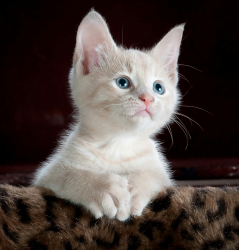

In [150]:
#The Shrinking Spell
img = cv2.imread('./cat.jpg')
width = int(img.shape[1] * 0.1)
height = int(img.shape[0] * 0.1)
dim = (width, height)
resized_image = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
cv2_imshow(resized_image)

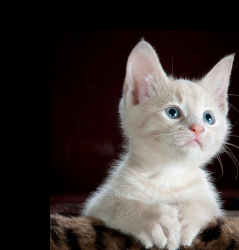

In [151]:
#The Teleportation Act:
img = resized_image
shift_x = 50  # shift right by 50 pixels
shift_y = 30  # shift down by 30 pixels
translation_matrix = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
translated_image = cv2.warpAffine(img, translation_matrix, (img.shape[1], img.shape[0]))
cv2_imshow(translated_image)

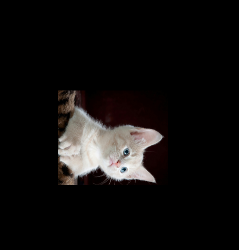

In [152]:
#The Twisting Tail Move
img = translated_image
rows,cols = img.shape[:2]
M = cv2.getRotationMatrix2D((cols/2,rows/2),-90,0.5)
dst = cv2.warpAffine(img,M,(cols,rows))
cv2_imshow(dst)

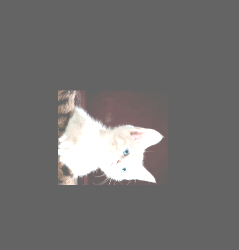

In [153]:
#The Sunbeam Glow
img = dst
bright_img = cv2.add(img, np.array([100, 100, 100], dtype=np.uint8))
cv2_imshow(bright_img)

Part 2


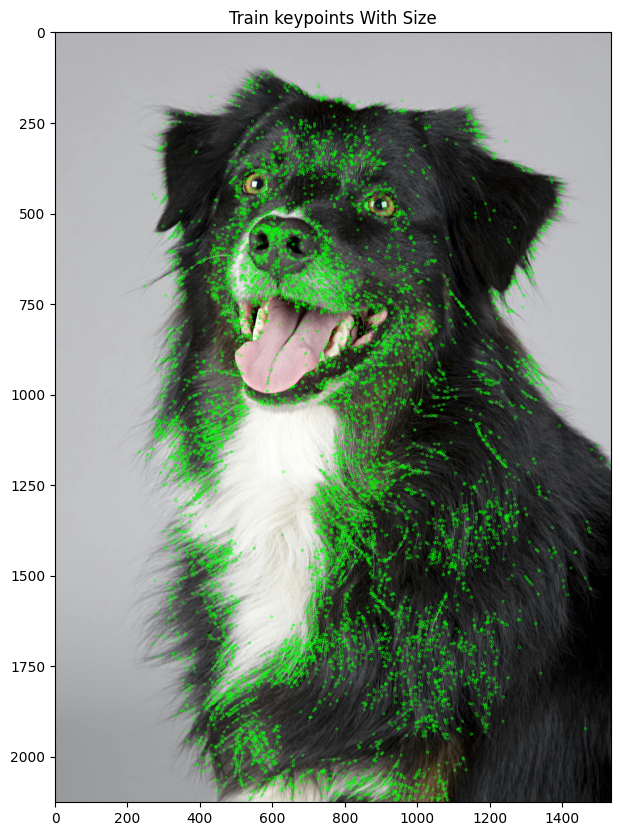

In [164]:
#1
image = cv2.imread('./dog.jpg')
original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

training_gray= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
test_gray = cv2.cvtColor(bright_img, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()

train_keypoints, train_descriptor = sift.detectAndCompute(training_gray, None)
test_keypoints, test_descriptor = sift.detectAndCompute(test_gray, None)

keypoints_without_size = np.copy(original_image)

cv2.drawKeypoints(original_image, train_keypoints, keypoints_without_size, color = (0, 255, 0))

# Display image with and without keypoints size
plt.figure(figsize=(20,10))
plt.title("Train keypoints With Size")
plt.imshow(keypoints_without_size)

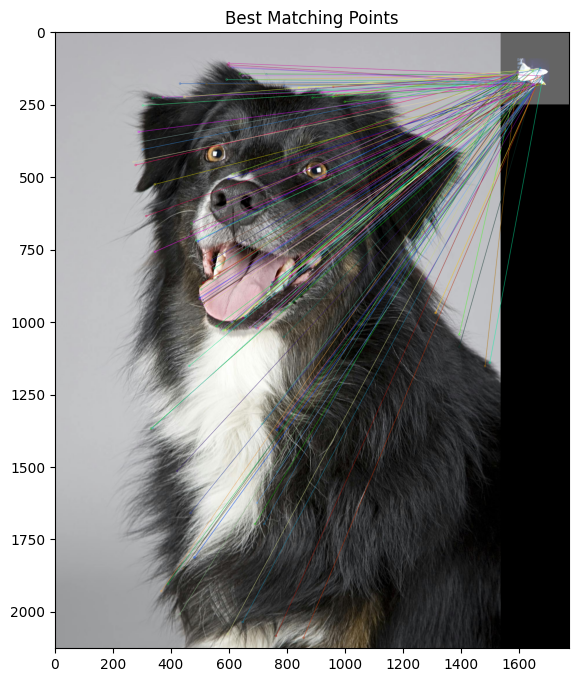


Number of Matching Keypoints Between The Training and Query Images:  10200


In [165]:
# Matching Keypoints
# Create a Brute Force Matcher object.
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck = False)

# Perform the matching between the SIFT descriptors of the training image and the test image
matches = bf.match(train_descriptor, test_descriptor)

# The matches with shorter distance are the ones we want.
matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(original_image, train_keypoints, bright_img, test_keypoints, matches[:150], None, flags = 2)

# Display the best matching points
plt.figure(figsize=(15,8))
plt.title("Best Matching Points")
plt.imshow(result)
plt.show()

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

4. SIFT may produce some incorrect matches between a cat and a dog due to shared textures or gradients, but it is unlikely to handle the "disguise" convincingly. For such semantic understanding, higher-level models (e.g., convolutional neural networks or object recognition models) are needed.

#QUESTION 3


Part 1

In [156]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [157]:
def harris_corner_detection(image, block_size=2, ksize=3, k=0.04):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, block_size, ksize, k)
    dst = cv2.dilate(dst, None)
    corners = np.zeros_like(image)
    corners[dst > 0.01 * dst.max()] = [0, 0, 255]  # Mark corners in red
    return corners

In [158]:
X_train = []
y_train = []

image_list = [f'image({i}).jpg' for i in range(1, 6)]
target_size = (224, 224)
for image_name in image_list:
    if image_name.endswith('.jpg') or image_name.endswith('.png'):  # Filter image files
        image = cv2.imread(image_name)
        resized_image = cv2.resize(image, target_size)

        # Apply Harris corner detection
        corner_image = harris_corner_detection(resized_image)

        # Add the corner image to X_train
        X_train.append(corner_image)

        # Label the image as 1 for corner detection (since Harris will always detect corners)
        # You can adjust the logic to create more complex labels
        y_train.append(1)  # For simplicity, labeling as 1 (corner detected)

X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (5, 224, 224, 3)
y_train shape: (5,)


In [159]:
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [160]:
def build_cnn_model(input_shape=(224, 224, 3)):
    model=Sequential()
    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(1000, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


    return model

# Define the model
model = build_cnn_model()

# Show summary of the model architecture
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_182 (Conv2D)                  │ (None, 222, 222, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_183 (Conv2D)                  │ (None, 220, 220, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_70 (MaxPooling2D)      │ (None, 110, 110, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_184 (Conv2D)                  │ (None, 108, 108, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_185 (Conv2D)                  │ (None, 106, 106, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_71 (MaxPooling2D)      │ (None, 53, 53, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_186 (Conv2D)                  │ (None, 51, 51, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_187 (Conv2D)                  │ (None, 49, 49, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_188 (Conv2D)                  │ (None, 47, 47, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_72 (MaxPooling2D)      │ (None, 23, 23, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_189 (Conv2D)                  │ (None, 21, 21, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_190 (Conv2D)                  │ (None, 19, 19, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_191 (Conv2D)                  │ (None, 17, 17, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_73 (MaxPooling2D)      │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_192 (Conv2D)                  │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_193 (Conv2D)                  │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_194 (Conv2D)                  │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_74 (MaxPooling2D)      │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 4096)                │       2,101,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 37,694,248 (143.79 MB)

 Trainable params: 37,694,248 (143.79 MB)

 Non-trainable params: 0 (0.00 B)

In [161]:
model.fit(X_train, tf.keras.utils.to_categorical(y_train,1000), epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.0000e+00 - loss: 6.9645 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 1.0000 - loss: 0

In [162]:
new_image = cv2.imread('./test.jpg')
corner_image = harris_corner_detection(new_image)  # Apply Harris Corner detection
corner_image_resized = cv2.resize(corner_image, (224, 224))  # Resize to the correct input size
corner_image_normalized = corner_image_resized / 255.0  # Normalize pixel values

# Reshape for a batch (the model expects a batch of images)
new_image_batch = np.expand_dims(corner_image_normalized, axis=0)

# Predict on the new image
prediction = model.predict(new_image_batch)
print("Prediction:", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
Prediction: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


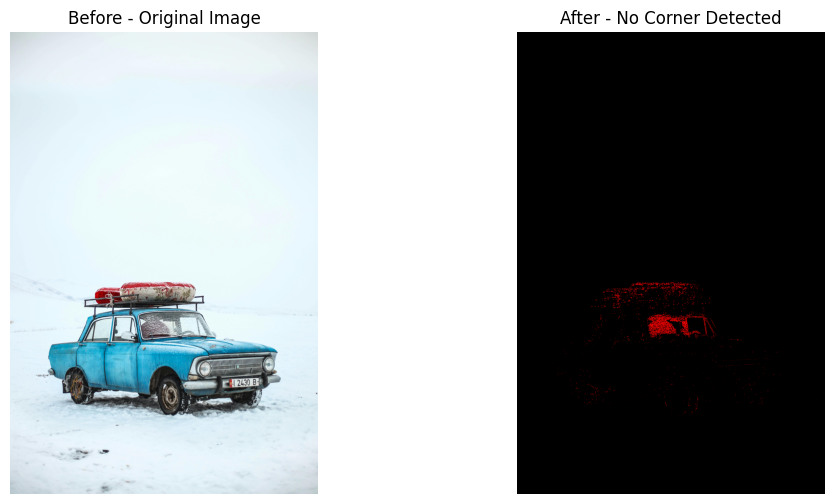

Prediction value: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [163]:
test_image_path = 'test.jpg'
test_image = cv2.imread(test_image_path)

# Apply Harris Corner Detection
corner_image = harris_corner_detection(test_image)

# Resize and normalize the image (resize to the same size as input to your model)
corner_image_resized = cv2.resize(corner_image, (224, 224))  # Ensure the same size as model input
corner_image_normalized = corner_image_resized / 255.0  # Normalize pixel values

# Reshape the image to match the model input (batch size of 1)
test_image_batch = np.expand_dims(corner_image_normalized, axis=0)

# Get the prediction from the model
prediction = model.predict(test_image_batch)

# Convert prediction to class label (assuming binary classification)
prediction_label = 'Corner Detected' if np.all(prediction[0]) > 0.5 else 'No Corner Detected'

# Display the before and after images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# "Before" image (Original)
axes[0].imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
axes[0].set_title("Before - Original Image")
axes[0].axis('off')  # Hide axes

# "After" image (With Corner Detection)
axes[1].imshow(cv2.cvtColor(corner_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
axes[1].set_title(f"After - {prediction_label}")
axes[1].axis('off')  # Hide axes

# Show the plot
plt.show()

# Optionally, display prediction value
print(f"Prediction value: {prediction[0]}")

#PART 2

Role of Each Layer in VGG-16 Architecture:

Convolutional Layers: Extract features from the input image like edges, textures, and patterns.
Use small 3×3 filters to capture fine details and reduce computational cost.

ReLU Activation: Adds non-linearity to the model, enabling it to learn complex patterns.

Max Pooling Layers: Reduce spatial dimensions, keeping important features and lowering computation.

Fully Connected Layers: Act as a classifier, combining extracted features to make predictions.

Softmax Layer: Outputs probabilities for each class.      

Why VGG-16 Uses Small Filters (3×3):

Better Feature Extraction: Multiple small filters stacked together capture the same information as larger filters but in more detail.

Reduced Parameters: Small filters have fewer weights, making the network computationally efficient.

Deep Architecture: Using small filters allows deeper networks, improving feature learning.
